# **Deep-Q-Network Agent**

In [1]:
import random
import torch
from collections import namedtuple
from torch import optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Neural Network Architecture

In [2]:
class QNetwork(torch.nn.Module):
    def __init__(self, seed, state_size, action_size):
        super(QNetwork, self).__init__()
        self.seed = seed
        self.fc1 = torch.nn.Linear(state_size, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, action_size)
        
        # TO-DO:
        # Hay algún tipo de capa que explote mejor las relaciones dinámicas de 
        # posición, velocidad y distancia a los objetos?
        
        # Investigar si las capas dropout o convolucionales producen mejores 
        # resultados
        
    def forward(self, input_state):
        x = F.relu(self.fc1(input_state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [3]:
def show_nn_graph():
    try:
        from torchviz import make_dot
    except Exception as ex:
        return f"No torchviz availabel: {str(ex)}"
    model = QNetwork(12, 37, 4)
    x = torch.randn(1, 37)
    return make_dot(model(x), params=dict(model.named_parameters()))

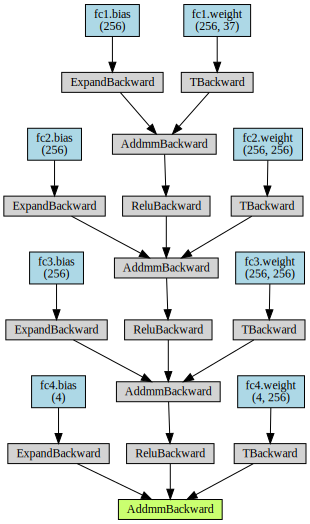

In [4]:
show_nn_graph()

### Sampling giving priority to experiences with reward 1

# Agent

In [5]:
class Agent:
    
    def __init__(self, state_size, action_size, seed, 
                 buffer_size=int(1e5), learn_after=10, 
                 minimum_replay_memory=124, LR=5e-4,
                 discount_rate=0.99, tau=1e-3):
        """
        The agent will use a Deep-Q-Network to find the best policy
        for the banana navigation problem. The policy is implicitly
        learned by the non-linear relationships stated by the deep neural 
        network.
        
        The Agent uses 2 reinforcement learning techniques to avoid
        sequence correlation and learning from its own predictions. 
        They are called Replay Buffer and Fixed-Q Targets, respectively.
        """
        # Environment Information
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.learn_after = learn_after
        self.minimum_replay_memory = minimum_replay_memory
        self.discount_rate = discount_rate
        self.tau = tau
        self.buffer_size = buffer_size
        self.LR = LR
        
        # FIXED-Q TARGETS: Initialization of networks.
        # This is done to avoid the network to learn from the
        # error function created from its own predictions 
        # (seen as the correct value). In other words,
        # as there is no ground truth, the agent has to inevitably
        # learn from its own past experiences. To do this in a 
        # more correct way, is updating the fixed target parameters
        # after a predefined number of time steps.
        
        # DOUBT: ¿Isn't the agent learning from too far experiences
        # if fixed-q-targets technique is used? Depending on the "learn_after" param.
        
        self.qnetwork_local = QNetwork(self.seed, self.state_size, self.action_size)
        self.qnetwork_target = QNetwork(self.seed, self.state_size, self.action_size)
        
        # Definition of the optimizer algorithm
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.LR)
        
        # REPLAY MEMORY: This buffer will store a maximum number of 
        # experiencies in the same way as a pile does. It contains
        # the standard s,a,r,s tuple of past experiencies to
        # draw examples from and perform a much less correlated
        # optimization.
        
        self.memory = ReplayBuffer(self.action_size, 
                                   self.buffer_size, 
                                   self.minimum_replay_memory, 
                                   self.seed)
        
        # Initialize time step - Used to decide when to learn
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """Store experiences and evaluate when is necessary to learn."""
        self.memory.add(state, action, reward, next_state, done)
        
        if self.t_step == self.learn_after:
            if len(self.memory) > self.minimum_replay_memory:
                experiences_batch = self.memory.sample()
                self.learn(experiences_batch, self.discount_rate)
            self.t_step = 0
        self.t_step = self.t_step + 1
    
    def act(self, state, eps=0.):
        """Select which action to perform based on the given state and policy"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiencies, discount_rate):
        """Update network weights based on the optimization performed with experiences"""
        states, actions, rewards, next_states, dones = experiencies
        
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        q_targets = rewards + (discount_rate * q_targets_next * (1 - dones))
        #print(f"Actions:\n{actions}")
        #print(f"Qnetwork given actions:\n{self.qnetwork_local(states)}")
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # We define now the loss function which states the mean squared error
        # between the q_expected parameters and the q_target
        loss = F.mse_loss(q_expected, q_targets)
        
        # We have to clear the gradients accumulated by Pytorch 
        # from the previous backward passes. We do that with zero_grad()
        self.optimizer.zero_grad()
        
        # With backward() we compute the numerical partial derivative for
        # each parameter defined in the loss function. These values are
        # accumulated in the input tensor
        loss.backward()
        
        # An optimizer step() updates the parameters based on the previously
        # calculated gradient (which is the vector of partial derivatives)
        self.optimizer.step()
        
        # Update Q network targets parameters based on the recently calculated
        # parameters from the Q network local
        # DOUBT: ¿Why this update is done like this?
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(
                self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
        

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
        

# Unity Environment

In [6]:
from unityagents import UnityEnvironment
import numpy as np

In [7]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [8]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Walk the environment

In [11]:
agent = Agent(action_size=action_size, state_size=state_size, seed=0)

In [12]:
import pylab as pl
from IPython import display
import time

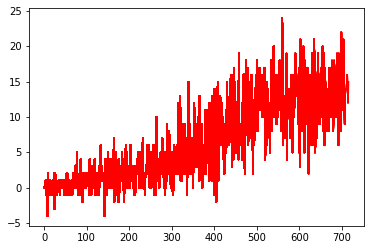

Episode 717	Average Score: 13.01

Environment solved in 617 episodes!	Average Score: 13.01


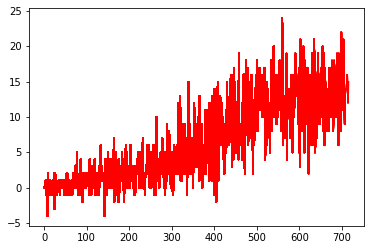

In [13]:
%matplotlib inline
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start 
    
    for i_episode in range(1, n_episodes+1):
        env_data = env.reset()[brain_name]
        score = 0
        
        for t in range(max_t):
            
            state = env_data.vector_observations[0]
            
            # Get action to perform
            action = agent.act(state, eps)
            
            # Get environment response to action
            env_data = env.step(action)[brain_name]
            
            next_state = env_data.vector_observations[0]  # Get state after action taken
            reward = env_data.rewards[0]  # Get reward after action taken
            done = env_data.local_done[0]  # Check if episode has finished
            
            # Make the agent store the experience and learn
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        pl.plot(scores, "-r")
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.01)
        #plt.clf()
        
        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 1 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
        
    return scores

scores = dqn()

### Save Q-Network Weights

In [15]:
torch.save(agent.qnetwork_local.state_dict(), "qnetwork_state_dict.pth")

### Scores Plot

In [16]:
import matplotlib.pyplot as plt

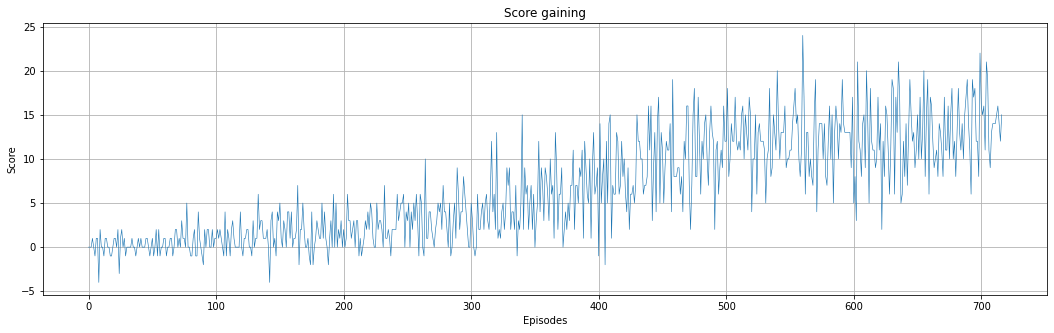

In [39]:
plt.figure(figsize=(18,5))
plt.title("Score gaining")
plt.plot(scores, linewidth=0.6, linestyle="-")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.grid(True)